In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Model
from keras.losses import MeanSquaredError
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input, Bidirectional
from tensorflow import keras
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [31]:
file = pd.read_json("data.json")
data = pd.DataFrame(file['MSFT']['chart'])
data.set_index('date',inplace = True)
data = data.filter(['close'])
data_len = len(data.values)
feature = 1

In [32]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.values)

# predict 360 days
test_size = 360 

# 14 days to predict the next day (sliding window)
window = 14 

#split the train data 
train_data = scaled_data[0:data_len-test_size-window,:]
x_train = []
y_train = []

for i in range(window, len(train_data)): 
  x_train.append(train_data[i-window:i])
  y_train.append(train_data[i, :])

x_train, y_train = np.array(x_train), np.array(y_train)

#split the test_data (for validation)
test_data = scaled_data[data_len-(window+test_size):data_len,:]
x_test = []
y_test = []
for i in range(window, len(test_data)):
  x_test.append(test_data[i-window:i])
  y_test.append(test_data[i, :])

x_test,y_test = np.array(x_test), np.array(y_test)

In [33]:
learning_rate = 0.03
input_model = Input(shape=(window, feature))

# randomly drop 20% training cell
dropout_layer = Dropout(0.2)

# first neurons layers 
Dense_window = Dense(window)

# output layer (1 for the only price output)
Dense_feature = Dense(1)

LSTM_MODEL = Bidirectional(LSTM(30,activation='tanh'))
output_layer1 = LSTM_MODEL(input_model)
output_layer2 = dropout_layer(output_layer1)
output_layer3 = Dense_window(output_layer2 )
output = Dense_feature(output_layer3)
model = Model(input_model,output)

model.summary()
model.compile(optimizer = keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 14, 1)]           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 60)               7680      
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 60)                0         
                                                                 
 dense_8 (Dense)             (None, 14)                854       
                                                                 
 dense_9 (Dense)             (None, 1)                 15        
                                                                 
Total params: 8,549
Trainable params: 8,549
Non-trainable params: 0
_________________________________________________________

In [34]:
predictions = model.predict(x_test)
print('r2_score: ',r2_score(y_test, predictions))
print('MAPE: ',mean_absolute_percentage_error(y_test, predictions))
print('MAE: ', mean_absolute_error(y_test, predictions))
print('MSE: ', mean_squared_error(y_test, predictions,squared=True))
print('rmse: ',mean_squared_error(y_test, predictions,squared=False))

12/12 [==============================] - 1s 2ms/step
r2_score:  0.9593365849146667
MAPE:  0.055266349719582504
MAE:  0.06166108011869854
MSE:  0.005805920600301895
rmse:  0.07619659178927818


C:\Users\lawre\AppData\Local\Temp\ipykernel_30104\68586901.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict['Predictions'] = predictions


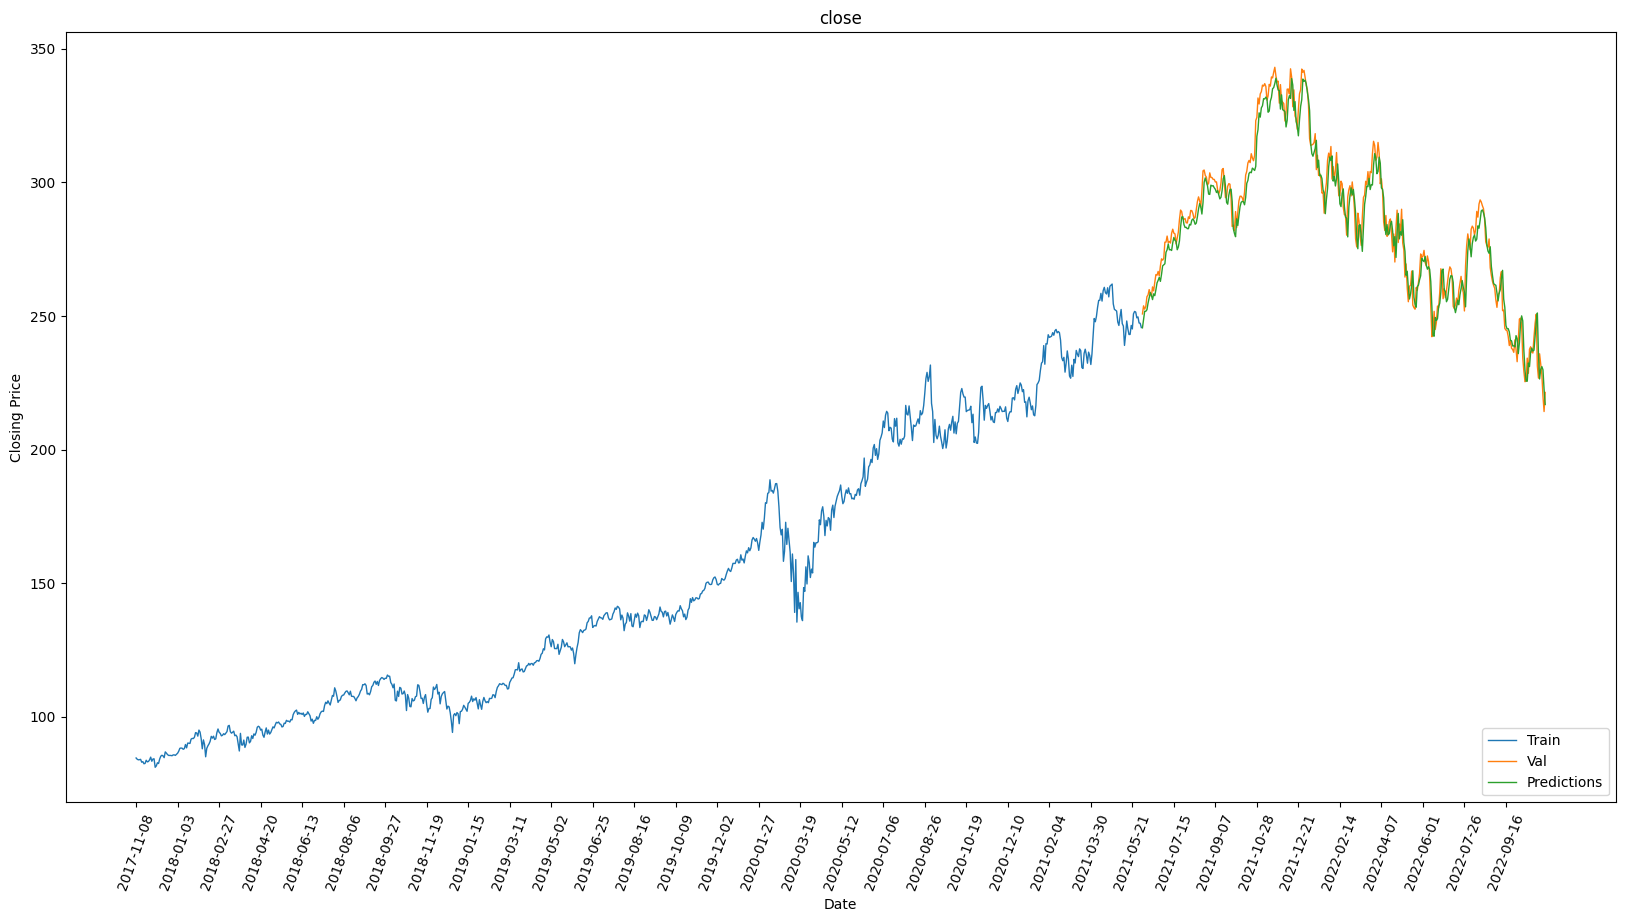

In [35]:
predictions = scaler.inverse_transform(predictions)
train = data[:data_len-test_size]
predict = data[data_len-test_size:data_len]
predict['Predictions'] = predictions
plt.figure(figsize=(20,10))
plt.title('close')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.plot(train['close'],linewidth=1)
plt.plot(predict[['close','Predictions']],linewidth=1)
plt.xticks(np.arange(0, len(data.values)+1,37),rotation=70)
plt.legend(['Train','Val','Predictions'], loc = 'lower right')
plt.show()

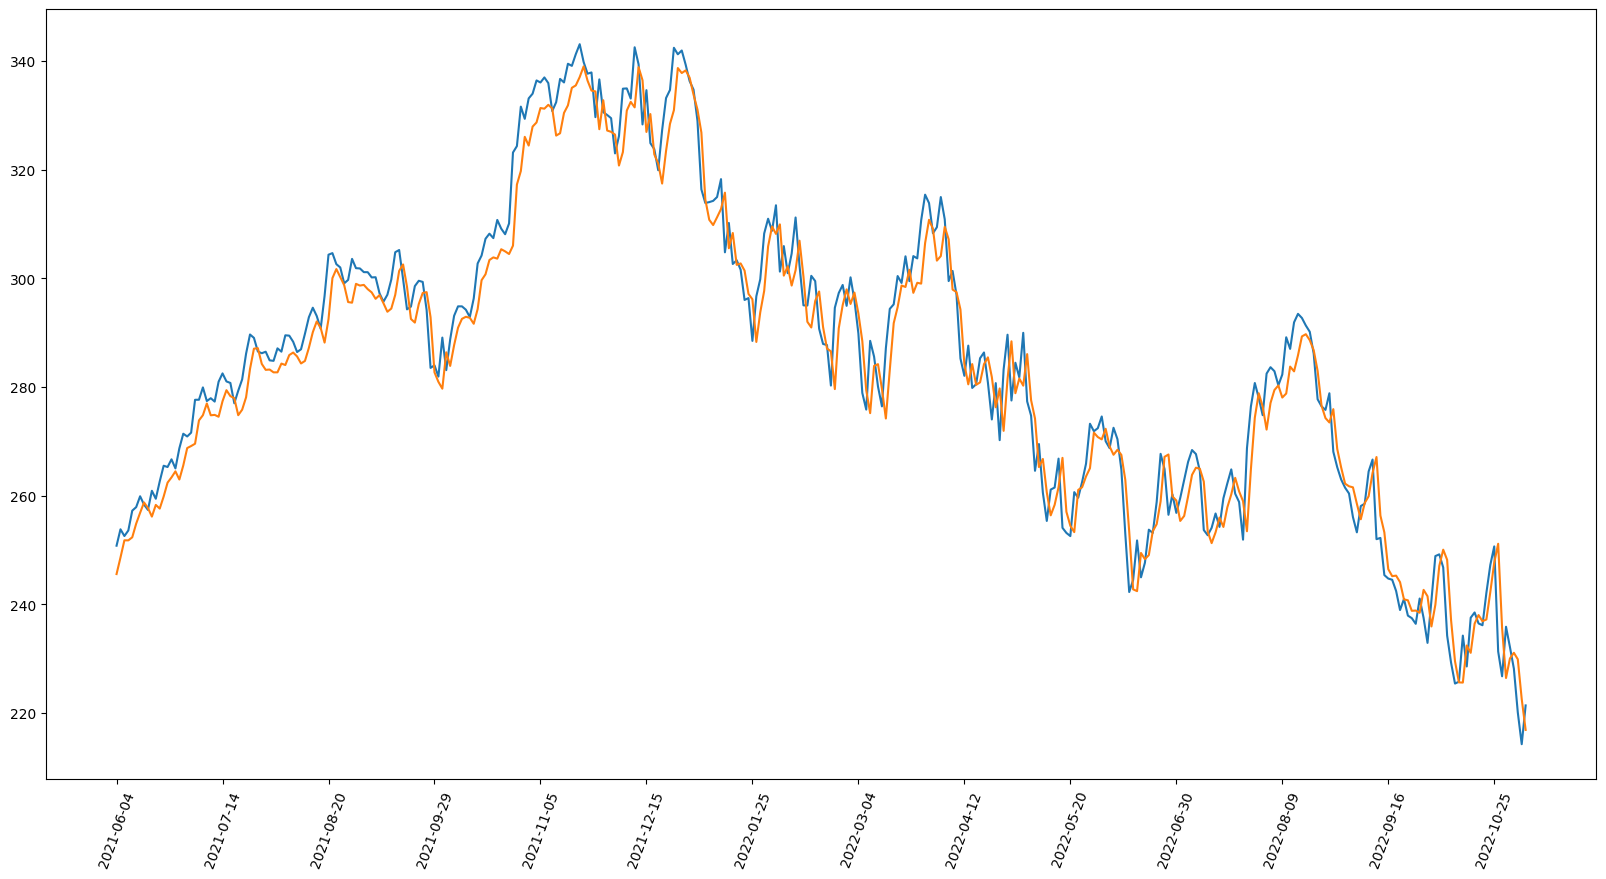

In [36]:
plt.figure(figsize=(20,10))
plt.xticks(np.arange(0, len(predict)+1,27),rotation=70)
plt.plot(predict[['close','Predictions']],linewidth=1.5)